## Exploratory Data Analysis

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
data_adult=pd.read_csv('C:/Users/Julia/Documents/_DATA SCIENCE/_Capstones/Capstone 2/Data/Data_adult.csv',index_col=0)
sns.set(style='ticks')
%matplotlib inline 

In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

In [3]:
data_adult.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4313 entries, 0 to 4313
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4313 non-null   object 
 1   age                4313 non-null   float64
 2   hypertension       4313 non-null   int64  
 3   heart_disease      4313 non-null   int64  
 4   ever_married       4313 non-null   object 
 5   work_type          4313 non-null   object 
 6   Residence_type     4313 non-null   object 
 7   avg_glucose_level  4313 non-null   float64
 8   bmi                4130 non-null   float64
 9   smoking_status     4313 non-null   object 
 10  stroke             4313 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 404.3+ KB


## Target feature:
### Since the goal of this project is to predict occurence of stroke, target feature is 'stroke'. It has 2 values: 1 - when a patient had a stroke, and 0  - when a patient did not have a stroke.

In [4]:
data_adult['stroke'].value_counts(normalize=True)*100

0    94.273128
1     5.726872
Name: stroke, dtype: float64

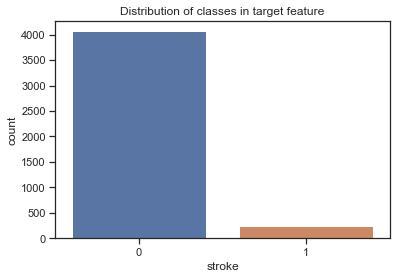

In [5]:
sns.countplot(data_adult['stroke'])
plt.title('Distribution of classes in target feature');

### It is obvious that target feature is highly imbalanced with only ~ 5.72 % of samples having a value of 1. This is a major issue and may require application of specialized feature engineering techniques as well as careful model selection and it may affect a perfomance of a selected model. 

In [6]:
data_adult.isna().any()

gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

### 'bmi' feature is the only one that has missing values

In [7]:
data_adult['bmi'].isna().sum()

183

In [8]:
percent_missing = data_adult['bmi'].isnull().sum() * 100 / len(data_adult)
print('Percentage of missing values in "bmi" feature:', round(percent_missing,2))

Percentage of missing values in "bmi" feature: 4.24


In [9]:
no_na = data_adult.dropna(subset="bmi")
no_na['stroke'].value_counts(normalize=True)*100

0    94.96368
1     5.03632
Name: stroke, dtype: float64

### Even though percentage of missing values in a dataset is relatively small, it is not a good idea to simply drop rows with missing values, as this will make target feature even more imbalanced.

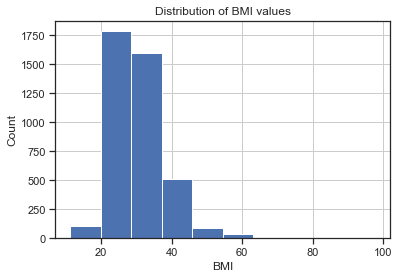

In [10]:
data_adult['bmi'].hist()
plt.title('Distribution of BMI values')
plt.xlabel('BMI')
plt.ylabel('Count');

### Distribution of 'bmi' values is skewed, meaning that we cannot impute missing values with the mean.

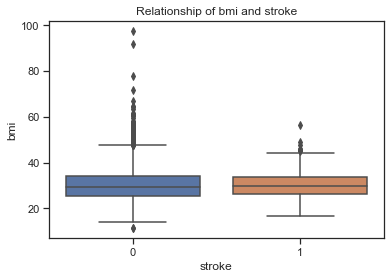

In [11]:
sns.boxplot(x="stroke", y="bmi", data=data_adult)
plt.title('Relationship of bmi and stroke');

### Since 'bmi' feature is scewed, the relationship between 'bmi' and target value is not clear. I think it would make sense to divide 'bmi' values into following categories:
* below 18.5 – underweight
* between 18.5 and 24.9 – healthy weight
* between 25 and 29.9 – overweight
* between 30 and 39.9 – obesity

In [12]:
for val in data_adult['bmi']:
    if val < 18.5:
        data_adult['bmi'].replace(to_replace=val, value='underweight', inplace=True)
    elif val >= 18.5 and val <= 24.9:
        data_adult['bmi'].replace(to_replace=val, value='normal', inplace=True)
    elif val >= 25 and val <= 29.9:
        data_adult['bmi'].replace(to_replace=val, value='overweight', inplace=True)
    elif val >= 30:
        data_adult['bmi'].replace(to_replace=val, value='obesity', inplace=True)

In [13]:
data_adult['bmi'].unique()

array(['obesity', nan, 'normal', 'overweight', 'underweight'],
      dtype=object)

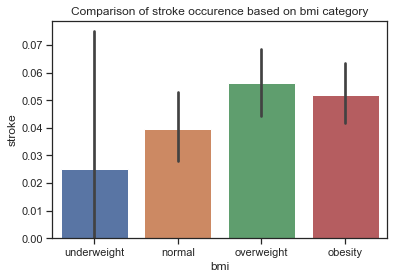

In [14]:
sns.barplot(x='bmi',y='stroke',data=data_adult, order=["underweight", "normal","overweight","obesity"])
plt.title('Comparison of stroke occurence based on bmi category');

### Plot above clearly shows that 'bmi' categories 'overweight' and 'obesity' have higher occurence of value 1 in the target feature.

### Continuous variables

In [15]:
data_adult.describe(include='float64')

,age,avg_glucose_level
count,4313.000000,4313.000000
mean,49.745885,108.226388
std,18.125129,47.568050
min,17.000000,55.120000
25%,35.000000,77.450000
50%,50.000000,92.270000
75%,64.000000,115.920000
max,82.000000,271.740000


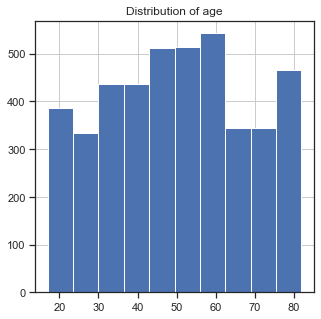

In [16]:
data_adult['age'].hist(figsize=(5,5))
plt.title('Distribution of age');

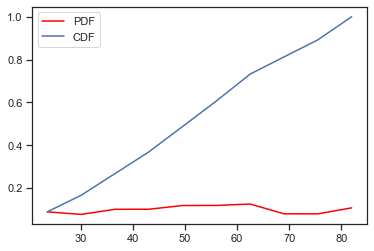

In [17]:
count, bins_count = np.histogram(data_adult['age'], bins=10)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.legend();

### 'age' feature has uniform distribution.

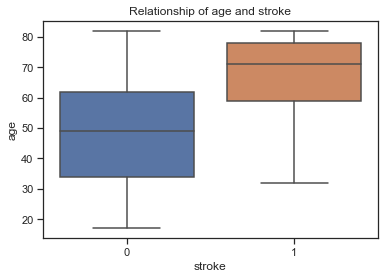

In [18]:
sns.boxplot(x='stroke', y='age', data=data_adult)
plt.title('Relationship of age and stroke');

In [19]:
data_adult['age_bin'] = pd.cut(data_adult['age'],
                         [0, 18, 30, 45, 60, 80, 99])

In [20]:
data_adult = data_adult.drop(columns=['age'])

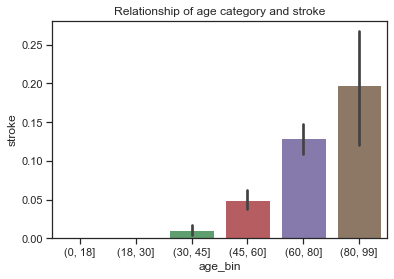

In [21]:
sns.barplot(x='age_bin', y='stroke', data=data_adult)
plt.title('Relationship of age category and stroke');

### The stroke occurs more often in people of higher age.

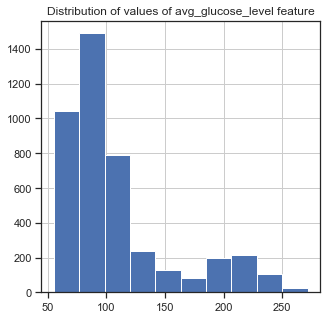

In [22]:
data_adult['avg_glucose_level'].hist(figsize=(5,5))
plt.title('Distribution of values of avg_glucose_level feature');

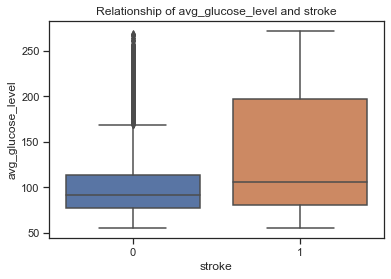

In [23]:
sns.boxplot(x='stroke', y='avg_glucose_level', data=data_adult)
plt.title('Relationship of avg_glucose_level and stroke');

In [24]:
for val in data_adult['avg_glucose_level']:
    if val < 140:
        data_adult['avg_glucose_level'].replace(to_replace=val, value='normal', inplace=True)
    elif val >= 140 and val < 200:
        data_adult['avg_glucose_level'].replace(to_replace=val, value='prediabetes', inplace=True)
    elif val >= 200:
        data_adult['avg_glucose_level'].replace(to_replace=val, value='diabetes', inplace=True)

In [25]:
data_adult.rename(columns = {'avg_glucose_level':'glucose_levels'}, inplace=True)

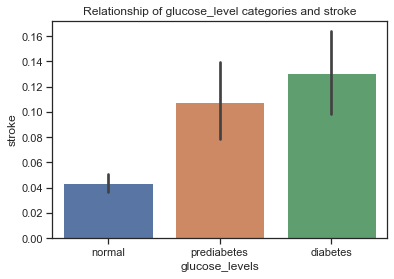

In [26]:
sns.barplot(x='glucose_levels',y='stroke',data=data_adult, order=["normal", "prediabetes","diabetes"])
plt.title('Relationship of glucose_level categories and stroke');

### Demographic features: gender,age

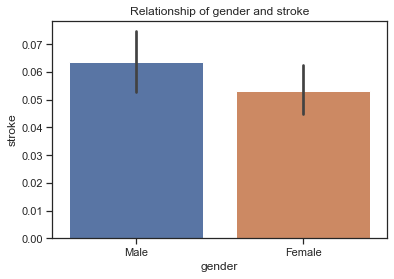

In [27]:
#fig, axes = plt.subplots(1,2,figsize=(10, 7))
sns.barplot(x='gender',y='stroke',data=data_adult)#ax=axes[0]
plt.title('Relationship of gender and stroke');

### Hypertension

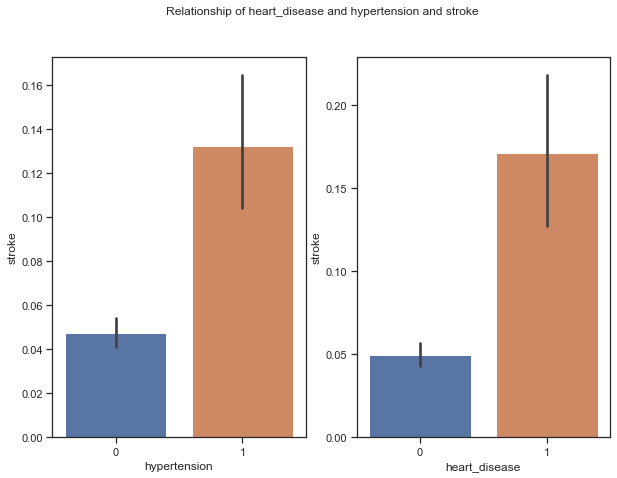

In [28]:
fig, axes = plt.subplots(1,2,figsize=(10, 7))
sns.barplot(ax=axes[0], x='hypertension',y='stroke',data=data_adult);
sns.barplot(ax=axes[1], x='heart_disease',y='stroke',data=data_adult);
fig.suptitle('Relationship of heart_disease and hypertension and stroke');

### Stress

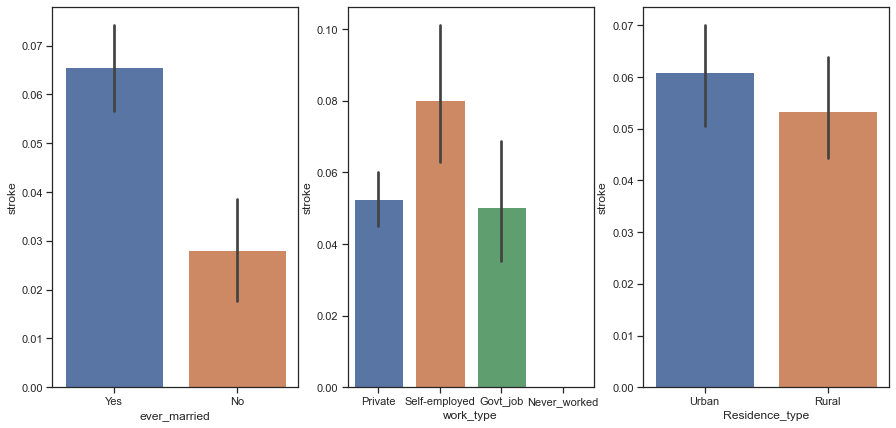

In [29]:
fig, axes = plt.subplots(1,3,figsize=(15, 7))
sns.barplot(ax=axes[0], x='ever_married',y='stroke',data=data_adult)
sns.barplot(ax=axes[1], x='work_type',y='stroke',data=data_adult)
sns.barplot(ax=axes[2], x='Residence_type',y='stroke',data=data_adult);

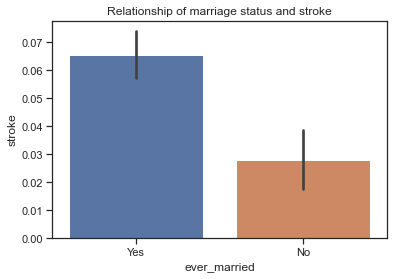

In [30]:
sns.barplot(x='ever_married',y='stroke',data=data_adult)
plt.title('Relationship of marriage status and stroke');

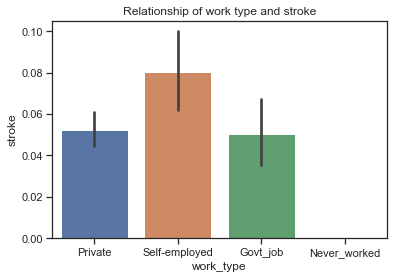

In [31]:
sns.barplot(x='work_type',y='stroke',data=data_adult)
plt.title('Relationship of work type and stroke');

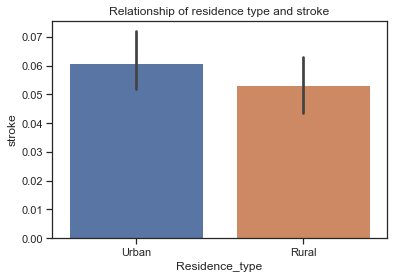

In [32]:
sns.barplot(x='Residence_type',y='stroke',data=data_adult)
plt.title('Relationship of residence type and stroke');

### Smoking status

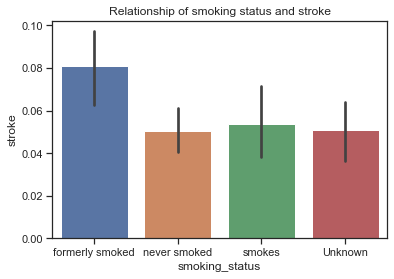

In [33]:
sns.barplot(x='smoking_status',y='stroke',data=data_adult)
plt.title('Relationship of smoking status and stroke');

## Inferential statistics

### Cramer’s V can be used to calculate the correlation between nominal categorical variables.

In [34]:
# Import association_metrics  
import association_metrics as am
# Convert you str columns to Category columns
df = data_adult.apply(
        lambda x: x.astype("category")) ##if x.dtype == "O" else x)
#df['bmi'] = df['bmi'].astype('object')
#df.bmi = df.bmi.fillna('unknown')
# Initialize a CamresV object using you pandas.DataFrame
cramersv = am.CramersV(df) 
# will return a pairwise matrix filled with Cramer's V, where columns and index are 
# the categorical variables of the passed pandas.DataFrame
res = cramersv.fit()

In [35]:
res

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,glucose_levels,bmi,smoking_status,stroke,age_bin
gender,1.000000,0.038170,0.104101,0.034664,0.012802,0.013253,0.070868,0.137143,0.097908,0.021733,0.081202
hypertension,0.038170,1.000000,0.095755,0.100888,0.096002,0.009689,0.169928,0.116282,0.092372,0.117027,0.242564
heart_disease,0.104101,0.095755,1.000000,0.068918,0.072161,0.001742,0.163332,0.055185,0.066124,0.127633,0.277365
ever_married,0.034664,0.100888,0.068918,1.000000,0.159862,0.003361,0.125550,0.162165,0.102945,0.067114,0.597063
work_type,0.012802,0.096002,0.072161,0.159862,1.000000,0.026453,0.041335,0.031152,0.049589,0.048857,0.223956
Residence_type,0.013253,0.009689,0.001742,0.003361,0.026453,1.000000,0.015179,0.031258,0.032552,0.016329,0.040583
glucose_levels,0.070868,0.169928,0.163332,0.125550,0.041335,0.015179,1.000000,0.116767,0.056774,0.128988,0.175598
bmi,0.137143,0.116282,0.055185,0.162165,0.031152,0.031258,0.116767,1.000000,0.042701,0.030518,0.147275
smoking_status,0.097908,0.092372,0.066124,0.102945,0.049589,0.032552,0.056774,0.042701,1.000000,0.051542,0.120257
stroke,0.021733,0.117027,0.127633,0.067114,0.048857,0.016329,0.128988,0.030518,0.051542,1.000000,0.240099


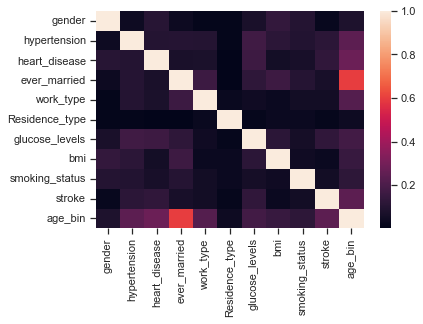

In [36]:
sns.heatmap(res);

## As we can see 'age_bin' and marriage_status show the strongest relationship with a score of ~ 0.6. 

### Feature selection

In [37]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from mlxtend.preprocessing import minmax_scaling
import scipy.stats
from sklearn.metrics import roc_auc_score

## Chi square test
### Null hypothesis: Predictor variable and target variable are independent
### If chi square score is higher that a critical values, null hypothesis can be rejected.

In [38]:
data_copy = data_adult.copy()
for col in data_copy.columns:
    data_copy[col] = LabelEncoder().fit_transform(data_copy[col])

In [39]:
features = [col for col in data_copy.columns if col != 'stroke']
X = data_copy[features]
y = data_copy['stroke']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=246)

In [42]:
p_values = {}
for col in X_train.columns:
    if col != 'stroke':
        crosstab = pd.crosstab(y_train, X_train[col])
        res = scipy.stats.chi2_contingency(crosstab)
        p_val = res[1]
        chi_2 = res[0]
        p_values[col] = [p_val,chi_2]

In [59]:
p_values

{'gender': [0.9279702373240513, 0.008171959634210546],
 'hypertension': [1.2031743711884602e-06, 23.572133053780075],
 'heart_disease': [9.554083022962726e-10, 37.41385840297273],
 'ever_married': [2.204363438788821e-05, 18.004042650798958],
 'work_type': [0.26625367184455145, 3.956009367393447],
 'Residence_type': [0.8646629998881807, 0.02905027779167716],
 'glucose_levels': [1.6006542848839677e-11, 49.71604709844915],
 'bmi': [7.805404988251196e-09, 43.58998035766836],
 'smoking_status': [0.48048202806381346, 2.471399428085015],
 'age_bin': [4.991757233218283e-33, 161.394853836603]}

In [46]:
res = pd.DataFrame(p_values).T.reset_index(level=0)

In [49]:
res = res.rename(columns={'index':'feature',0:'p_value',1:'chi_2'})

In [53]:
res = res.sort_values(by='p_value',ascending=True).reset_index(drop=True)

In [55]:
res[res['p_value'] <= 0.05]

,feature,p_value,chi_2
0,age_bin,4.991757e-33,161.394854
1,glucose_levels,1.600654e-11,49.716047
2,heart_disease,9.554083e-10,37.413858
3,bmi,7.805405e-09,43.589980
4,hypertension,1.203174e-06,23.572133
5,ever_married,2.204363e-05,18.004043


In [57]:
res

,feature,p_value,chi_2
0,age_bin,4.991757e-33,161.394854
1,glucose_levels,1.600654e-11,49.716047
2,heart_disease,9.554083e-10,37.413858
3,bmi,7.805405e-09,43.589980
4,hypertension,1.203174e-06,23.572133
5,ever_married,2.204363e-05,18.004043
6,work_type,2.662537e-01,3.956009
7,smoking_status,4.804820e-01,2.471399
8,Residence_type,8.646630e-01,0.029050
9,gender,9.279702e-01,0.008172


In [ ]:
critical_values = {}
for col in X_train.columns:
    if col != 'stroke':
        crosstab = pd.crosstab(y_train, X_train[col])
        df = (len(crosstab.index)-1)*(len(crosstab.columns)-1) #degrees of freedom
        crit_val = scipy.stats.chi2.ppf(0.95, df=df)
        critical_values[col] = crit_val

In [111]:
crosstab = pd.crosstab(y_train, X_train["glucose_levels"].values == 1)
res = scipy.stats.chi2_contingency(crosstab)

In [94]:
data_adult.glucose_levels.value_counts()

normal         3542
diabetes        427
prediabetes     344
Name: glucose_levels, dtype: int64

In [93]:
X_train.glucose_levels.value_counts()

1    2462
0     314
2     243
Name: glucose_levels, dtype: int64

In [65]:
X_train

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,glucose_levels,bmi,smoking_status,age_bin
2613,0,0,1,0,0,1,0,1,0,4
1870,1,0,0,1,2,1,0,1,1,3
4281,0,0,0,0,2,1,1,2,2,1
2190,0,0,0,1,2,0,1,0,3,1
1599,0,0,0,0,2,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
3363,0,0,0,1,3,1,0,2,2,4
2606,0,0,0,1,3,0,1,1,1,3
2112,0,0,0,0,0,0,0,2,2,3
1668,0,0,0,1,3,0,1,1,0,3


In [64]:
res

(0.0,
 1.0,
 0,
 array([[2850.],
        [ 169.]]))

In [ ]:
crit_values = pd.DataFrame.from_dict(critical_values,orient='index')

In [ ]:
selection_model = SelectKBest(score_func=chi2, k=10).fit(X_train, y_train)
feature_score = pd.DataFrame({'features': X_train.columns.values, 'scores':selection_model.scores_})

In [ ]:
df = pd.merge(crit_values,feature_score,left_index=True, right_on='features')

In [ ]:
df = df.rename(columns={0:'critical value'})

In [ ]:
df.sort_values(by='scores',ascending=False).reset_index(drop=True)

In [ ]:
feature_score.sort_values(by='scores',ascending=False).plot(x='features',kind='bar',title='Chi-squared scores');

## As we can see, critical value is higher than chi square score for features 'work_type','smoking_status','Residence_type' and 'gender' indicating that these features and target feature are independent.

In [ ]:
data_adult.head()

## Building a model to get feature importance

In [ ]:
features = [col for col in data_adult.columns if col != 'stroke']
X = data_adult[features] 
y = data_adult[['stroke']] 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=246)

In [ ]:
X_train_dummies = pd.get_dummies(X_train,drop_first=True)
X_test_dummies = pd.get_dummies(X_test,drop_first=True)

In [ ]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(objective= 'binary:logistic', eta=0.01, n_estimators=200, 
                        max_depth=8, colsample_bytree=0.8, seed=47, use_label_encoder=False)

In [ ]:
def replace_char(df):
    df.columns = df.columns.str.replace("_", "")
    df.columns = df.columns.str.replace(",", "")
    df.columns = df.columns.str.replace("]", "")
    df.columns = df.columns.str.replace("[", "")

In [ ]:
replace_char(X_train_dummies)
replace_char(X_test_dummies)

In [ ]:
xgb_clf.fit(X_train_dummies, y_train, verbose=True)

In [ ]:
y_pred_probs = xgb_clf.predict_proba(X_train_dummies)[:,1]
roc_auc_score(y_train.values, y_pred_probs)

In [ ]:
df_feature_imp = pd.DataFrame(X_train_dummies.columns,columns=['feature'])
df_feature_imp['importance'] = xgb_clf.feature_importances_
df_feature_imp.sort_values(by='importance', ascending=False, inplace=True)
df_featture_imp_top = df_feature_imp.head(20)

fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(x ='importance', y='feature', data = df_featture_imp_top)
plt.title('Feature Importance - Top 20')
plt.show()